# Computational Biophysics Homework - HP model

Tommaso Peviani

### Summary

This notebook explores some features of the Hydrophobic-Polar model on a 2D square lattice. The code is an extension of the notebook provided in the hands-on session on the HP model. We compute the number of spatial conformations as a function of the chain length and of the number of topological contacts. Then, we study the distribution in the sequence space of quantities such as native state degeneracy, compactness and core hydrophobicity. All the results are compared with those provided in the articles [1] and [2].

**Bibliography**

[1] Hue Sun Chan and Ken A. Dill, Macromolecules 1989 22 (12), 4559-4573,  DOI: 10.1021/ma00202a031

[2] Kit Fun Lau and Ken A. Dill, Macromolecules 1989 22 (10), 3986-3997, DOI: 10.1021/ma00200a030



**NOTE:** the string variable `path` contains the file path to the folder containing all the images displayed in the notebook. Since the pictures'directory and the notebook's working directory are the same, in principle one should not need to specify the full path. Anyway, if images are not loaded properly, it could be necessary to modify the `path` string suitably. 

In [1]:
path = './'

## Recap of the Hydrophobic-Polar model

In the Hydrophobic-Polar (HP) model, a protein is described as a chain of $N$ residues, each of which can be of one of the two following types: hydrophobic ($H$) or polar ($P$). The sequence of letters denoting the residues' type identifies a particular protein. The chain lives on a periodic lattice (2D or 3D, with many possible choices for the connectivity $z$): in our case, we study 2D square lattices. In order to model excluded volume effects, different residues cannot occupy the same lattice site, so that the chain configuration describes a self-avoiding walk on the lattice.

Given a configuration $i$ of the chain, we say that there is a **topological contact** whenever a couple of residues, which are not successive in the chain sequence, occupy neighbour sites on the lattice. We can then define the following quantities
$$
\begin{align}
&t \equiv t(i) = \text{ Number of topological contacts} \\
&m \equiv m(i) = \text{ Number of } HH \text{ topological contacts }
\end{align}
$$
For a chain of length $N$, we define the maximum number of topological contacts - of any type and of $HH$ type respectively - over all possible configurations as
$$
\begin{align}
& t_{max} \equiv \max_i \{ t(i) \} \\
& s \equiv \max_i \{ m(i) \} \\
\end{align}
$$
We associate a free-energy contribution $\Delta F$ to each type of topological contact
$$
\begin{align}
HH \text{ contact}\rightarrow \beta \Delta F_{HH} \equiv \epsilon_{HH} \\
HP \text{ contact}\rightarrow \beta \Delta F_{HP} \equiv \epsilon_{HP} \\
PP \text{ contact}\rightarrow \beta \Delta F_{PP} \equiv \epsilon_{PP} \\
\end{align}
$$
The simplest choice, adopted in the following of this work, is 
$$
\epsilon_{HH}=-1, \quad \epsilon_{HP} = \epsilon_{PP} = 0
$$
then in this case the free energy of a conformation $i$ is given by
$$
\beta F(i) = \epsilon_{HH} \cdot m(i)  = - m(i)
$$
Finally, we define *native state* a configuration $i^*$ that minimizes the free energy, which in our case correnponds to maximize the number of $HH$ contacts
$$
i^* = \argmin_{i} \{ E(i) \} = \argmax_{i} \{ m(i) \}
$$
The native states for a given sequence, as we will discuss later, can be more than one.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import random
import itertools
import tqdm as tqdm

## 0. Defining functions

### 0.0 Code from the hands-on notebook

This section just contains the functions defined in the hands-on notebook. The single cell from the original notebook was unpacked in many cells. I added some textual explanations and some testing of the functions, in order to get acquainted with them. They are the same as in the original version, so the reading of this part can be skipped.

In [3]:
# On a square lattice there are four possible directions (up, right, down, left)
DIRECTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0)]

#### Conformations

The function `generate_conformations()` generates all conformations of a chain of length $N$, which are distinct apart from
- rotations: this is ensured by the fact that configurations are generated recursively from a single configuration with $N=2$
    \begin{equation}
    \{ (x_1=0,y_1=0), (x_2=0,y_2=1) \}
    \end{equation}
    so the $x$ and $y$ directions are no longer equivalent for any self-avoiding walk used to generate a configuration with $N>2$. If one instead started from a $N=1$ configuration, then $x$ and $y$ directions would be equivalent and one would have to explicitly remove a-posteriori the rotationally equivalent conformations;
- reflections with respect to an axis:  this is achieved by simultaneously generating a configuration and its mirror image upon reflection on the $x$-axis, and then including just one of them in the conformation list.

In [4]:
# Return all possible conformations of a given length
def generate_conformations(length):
    # there is a single conformation of length 2 that is not related to others by rotations or translations
    if length == 2:
        return [[(0, 0), (0, 1)]] # this return stops the recursion of the next line
    
    # Recursive call: get all possible conformations for length - 1
    smaller_conformations = generate_conformations(length - 1)
    conformations = []
    
    for conf in smaller_conformations:
        last_point = conf[-1]
        for direction in DIRECTIONS:
            new_point = (last_point[0] + direction[0], last_point[1] + direction[1])
            if new_point not in conf: # check that there are no overlaps
                # generate the new configuration
                new_conf = conf + [new_point]
                # generate its mirror image
                mirror_conf = [(-x, y) for x, y in new_conf]
                # pick one of the two using the lexographic order through min
                conformations.append(min(new_conf, mirror_conf))
    
    # make sure that only one of the two mirror images of each configuration is retained
    conformations.sort()
    return list(conformations for conformations, _ in itertools.groupby(conformations))

In [5]:
# testing generate_conformations()
for n in range(2,5):
    print('\nChain length = ', n)
    print('conformations:')
    confs = generate_conformations(n) 
    for c in confs: print(c)


Chain length =  2
conformations:
[(0, 0), (0, 1)]

Chain length =  3
conformations:
[(0, 0), (0, 1), (-1, 1)]
[(0, 0), (0, 1), (0, 2)]

Chain length =  4
conformations:
[(0, 0), (0, 1), (-1, 1), (-2, 1)]
[(0, 0), (0, 1), (-1, 1), (-1, 0)]
[(0, 0), (0, 1), (-1, 1), (-1, 2)]
[(0, 0), (0, 1), (0, 2), (-1, 2)]
[(0, 0), (0, 1), (0, 2), (0, 3)]


In [6]:
# Check if two points are adjacent in the lattice
def is_adjacent(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1]) == 1

In [7]:
# testing is_adjacent()
points = [ [0,0], [0,1], [0,2] ]
for i in range(len(points)):
    for j in range(i+1,len(points)):
        print('points', i,',',j,' adjacent: ', is_adjacent(points[i],points[j]))

points 0 , 1  adjacent:  True
points 0 , 2  adjacent:  False
points 1 , 2  adjacent:  True


In [8]:
# Return the number t of topological contacts in a conformation
def count_topological_contacts(conformation):
    count = 0
    length = len(conformation)
    for i in range(length):
        for j in range(i + 2, length): # + 2 to skip connected neighbours
            if is_adjacent(conformation[i], conformation[j]):
                count += 1
    return count

In [9]:
# testing count_topological_neighbours()
confs = generate_conformations(4) 
for c in confs:
    t = count_topological_contacts(c)
    print('conformation: ', c , ',  # topological contacts = ', t)

conformation:  [(0, 0), (0, 1), (-1, 1), (-2, 1)] ,  # topological contacts =  0
conformation:  [(0, 0), (0, 1), (-1, 1), (-1, 0)] ,  # topological contacts =  1
conformation:  [(0, 0), (0, 1), (-1, 1), (-1, 2)] ,  # topological contacts =  0
conformation:  [(0, 0), (0, 1), (0, 2), (-1, 2)] ,  # topological contacts =  0
conformation:  [(0, 0), (0, 1), (0, 2), (0, 3)] ,  # topological contacts =  0


In [10]:
# Plot the conformation, with each residue coloured according to the sequence
def plot_conformation(conformation, sequence):
    # define colors for H and P residues
    color_map = {'H': 'blue', 'P': 'red'}
    # used to shift the 'H' and 'P' labels so that they do not overlap with the symbols
    label_shift = 0.05
    
    # extract x and y coordinates
    x_coords, y_coords = zip(*conformation)
    
    # plot the conformation as a line connecting points
    plt.plot(x_coords, y_coords, color='black', linestyle='-', marker='o', linewidth=2)
    
    # plot each residue with its corresponding color
    for i, (x, y) in enumerate(conformation):
        plt.plot(x, y, marker='o', color=color_map[sequence[i]], markersize=10)
        # the first residue is labelled differently to highlight where the chain begins
        if i == 0:
            label = sequence[i] + " (N)"
        else:
            label = sequence[i]
        plt.text(x - label_shift, y + label_shift, label, fontsize=12, ha='right', va='bottom')

    plt.axis('equal')
    plt.grid(True)
    #plt.title(f"Conformation for sequence: {sequence}")
    plt.axis('off')
    plt.show()

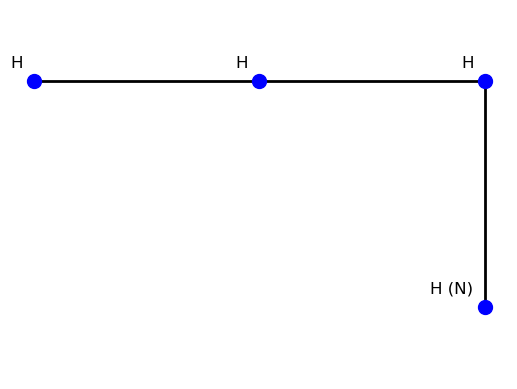

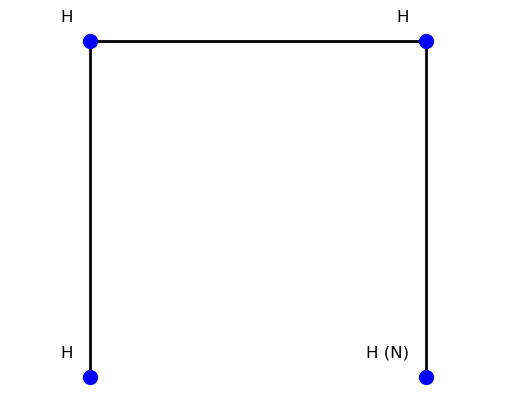

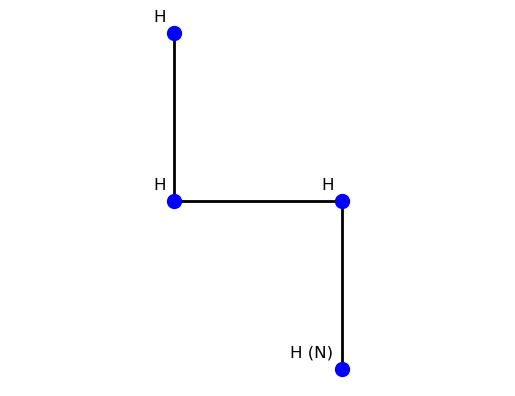

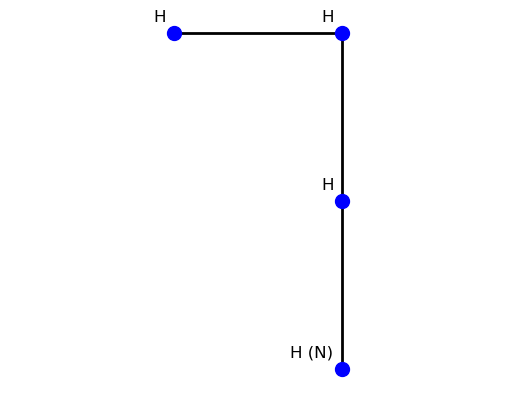

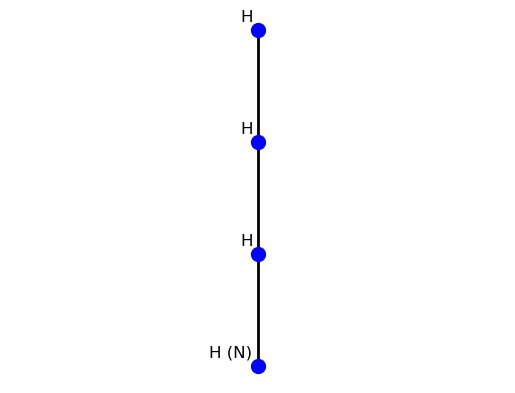

In [11]:
seq = "HHHH"
for c in confs: plot_conformation(c,seq)

**NOTE**: if the two ends of the chain were considered as equivalent (i.e. undirected chain), then conformations 0 and 3 would mapped one into the other upon a $\pi/2$ rotation and a $x \rightarrow -x$ reflection (from a purely geometric standpoint, i.e. without considering different $H$ or $P$ residue types). Anyway, we are assuming by convention that the chain has distinguishable ends, one of which is assumed as the start and is denoted by a N letter in the plots.

In [12]:
# Return the conformations with the maximum compactness (i.e. with the maximum number of topological contacts)
def select_compact_conformations(conformations):
    max_topological_contacts = 0
    compact_conformations = []

    for conf in conformations:
        topological_contacts = count_topological_contacts(conf)
        if topological_contacts > max_topological_contacts:
            max_topological_contacts = topological_contacts
            compact_conformations = [conf]
        elif topological_contacts == max_topological_contacts:
            compact_conformations.append(conf)
    
    return max_topological_contacts, compact_conformations

# topological contacts in compact conformations =  1
Plotting compact conformations for N=4:


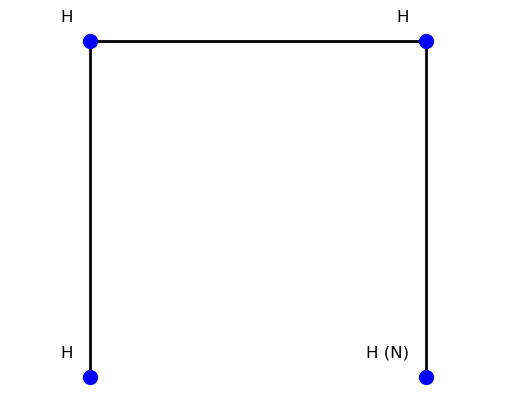

In [13]:
# testing select_compact_conformations()

t_max, confs_compact = select_compact_conformations(confs)
print('# topological contacts in compact conformations = ', t_max)
print('Plotting compact conformations for N=4:')
for c in confs_compact: plot_conformation(c, 'HHHH')


#### Sequences and energy

Given a chain of length $N$, the sequence of the resiude types (either hydrophobic or polar) is represented as a string of $N$ characters, each of which can be `H` or `P`. The function `generate_all_sequences()` is used to create all possible strings of a given number of characters. As we said before, the chain spatial conformations have a defined direction, and therefore we need to consider sequences that are equal upon inversion of the order of the characters as distinct.

In [14]:
# generates all possible strings of #characters=length, made by combining 'H' and 'P' 
def generate_all_sequences(length):
    return [''.join(seq) for seq in itertools.product('HP', repeat=length)]

In [15]:
# testing generate_all_sequences()
for length in range(4):
    print(generate_all_sequences(length))

['']
['H', 'P']
['HH', 'HP', 'PH', 'PP']
['HHH', 'HHP', 'HPH', 'HPP', 'PHH', 'PHP', 'PPH', 'PPP']


In [16]:
# Return the energy of a conformation for a given HP sequence
def calculate_energy(conformation, sequence):
    energy = 0
    length = len(conformation)
    for i in range(length):
        if sequence[i] == 'H':
            for j in range(i + 2, length): # + 2 to skip connected neighbours
                if sequence[j] == 'H' and is_adjacent(conformation[i], conformation[j]):
                    energy -= 1
    return energy

In [17]:
seqs = generate_all_sequences(4)
c = confs_compact[0]
for s in seqs:
    print(s, ' energy=', calculate_energy(c,s))

HHHH  energy= -1
HHHP  energy= 0
HHPH  energy= -1
HHPP  energy= 0
HPHH  energy= -1
HPHP  energy= 0
HPPH  energy= -1
HPPP  energy= 0
PHHH  energy= 0
PHHP  energy= 0
PHPH  energy= 0
PHPP  energy= 0
PPHH  energy= 0
PPHP  energy= 0
PPPH  energy= 0
PPPP  energy= 0


In [18]:
# Return the lowest energy conformations
def find_lowest_energy_conformations(sequence, conformations):
    length = len(sequence)
    if length != len(conformations[0]):
        print(f"The length of the sequence ({length}) is different from that of the conformations ({len(conformations[0])})")
    lowest_energy = float('inf')
    lowest_energy_conformations = []

    for conf in conformations:
        energy = calculate_energy(conf, sequence)
        if energy < lowest_energy:
            lowest_energy = energy
            lowest_energy_conformations = [conf]
        elif energy == lowest_energy:
            lowest_energy_conformations.append(conf)

    return lowest_energy, lowest_energy_conformations

In [19]:
seq = 'HPPH'
E_min, conf_E_min = find_lowest_energy_conformations(seq,confs) 
print('E_min = ', E_min)
print('Native config: ', conf_E_min)

E_min =  -1
Native config:  [[(0, 0), (0, 1), (-1, 1), (-1, 0)]]


### 0.1 Additional functions

The functions in this section are original material of this work.

#### Compactness

Given a conformation $i$ of a chain of length $N$, we define its compactness as
$$
\rho(i) = \frac{t(i)}{t_{max}}
$$
where $t_{max}$ is the maximum number of topological contacts for that chain.
We define a function `compute_compactness()` that takes a list of conformations as arguments, and then:
1. computes $t(i)$ for each conformation 
2. finds the maximum values $t_{max}$ 
3. returns the compactness values $\rho(i) = t(i)/t_{max}$ for each conformation

**NOTE**: the returned $\rho$ values are correctly normalized only if, in the input list of configurations, at least one is maximally compact. In the following, we will always feed this function with lists that satisfy this requirement.

In [20]:
# argument: list of conformations (at least one must be maximally compact)
# returns: list of rho values, t_max 
def compute_compactness(conformations):
    rhos = []
    t_max = 0
    for c in conformations:
        t = count_topological_contacts(c) 
        rhos.append( t )
        if t_max < t: t_max = t
    # normalize compactness values
    for i in range(len(rhos)):
        rhos[i] =  rhos[i] / t_max
    return rhos, t_max

In [21]:
# testing 
N = 4
confs = generate_conformations(N)
rhos, t_max = compute_compactness(confs)
print(f'Compactness values fo N={N}: ',rhos)

Compactness values fo N=4:  [0.0, 1.0, 0.0, 0.0, 0.0]


### Core hydrophobicity

Given a chain conformation $i$, we define its *core* as the set of residues that are completely surrounded by other residues, i.e. for which all the first-neighbour sites on the lattice are occupied. We denote by $n_i$ the number of core residues in conformation $i$, and by $n_{hi}$ the number of $H$ core residues. The *core hydrophobicity* is then defined as the ratio
$$
x_i = \frac{n_{hi}}{n_i}
$$
How can we compute such a quantity? A possible simple implementation is the following. 

First, we identify the residues in the core with a function `find_core()`, which for each residue $j=1,...,N$ in the chain:
1. checks for all other residues $k\neq j$ if they are adjacent to $j$, i.e. $ |x_j-x_k| + |y_j-y_k| = 1 $;
2. counts the number $a_j$ of residues adjacent to $j$;
3. if $a_j=z$, where $z$ is the lattice connectivity (in a 2D square lattice $z=4$), then assigns $j$ to the core.

This method is $\mathcal{O}(N^2)$, so it is not particularly efficient for large $N$, and probably some smarter strategy could be devised: anyway, it allows to compute the values of $<x>_{ns}$ (average on native state) in the following sections in the same loops where $g(s)$ and $<\rho>_{ns}$ are calculated, without significantly increasing the execution time.

Then, when the core residues have been identified, we can compute $x_i$ with the function `compute_core_hydrophobicity()`, which takes the core residues' indices and the `HP` sequence as arguments.

In [22]:
# O(N**2) method to find core residues

def find_core(conformation):
    core_idx = [] # indices of the core residues in the chain
    core_pos = [] # lattice positions of core residues
    length = len(conformation)
    # for each residue in conformation
    for i in range(length):
        # count number of adjacent residues
        count = 0
        for j in range(length): # for all residue in chain
            if is_adjacent(conformation[i], conformation[j]): # true only if distance = 1 (i=j self-term not a problem)
                count += 1
        # if number of neighbour residues is exactly 4, residue i is in the core
        if count == 4: 
            core_idx.append(i)
            core_pos.append(conformation[i])
    # returns the indices 
    return core_idx, core_pos

In [23]:
# compute x_i = n_hi / n_i for a conformation i
# imput: core residues' indices (output of previous function), HP sequence 

def compute_core_hydrophobicity(core_idx,sequence):
    n_i = len(core_idx)
    n_hi = 0
    # if there is no core, direclty return 0 (to avoid dividing by 0)
    if n_i == 0:
        return  0
    # otherwise count H coe residues and compute ratio
    else:
        for i in core_idx:
            if sequence[i]=='H':
                n_hi += 1
        return n_hi / n_i

In [24]:
# testing
seqs = generate_all_sequences(10)
confs = generate_conformations(10)
_ , compact_confs = select_compact_conformations(confs)

c = compact_confs[50]
s = seqs[50]
print('sequence: ', s)

core_idx, core_pos = find_core(c)
print('core residues: ', core_idx)

x = compute_core_hydrophobicity(core_idx,s)
print('core hydrophobicity x =', x)

sequence:  HHHHPPHHPH
core residues:  [0, 5]
core hydrophobicity x = 0.5


## 1. Reproducing Chan&Dill (1989) results

### 1.1 Enumerating conformations

Following the notation of the original article [1], let the number of distinct conformations for a chain of length $N$ be
$$
\Omega(N) = \sum_{t=0}^{t_{max}} \Omega^{(t)} (N)
$$
where $\Omega^{(t)}(N)$ is the number of conformations with $t$ topological contacts. We now want to compute $\Omega(N)$ and $\{\Omega^{(t)}(N)\}_{t=0}^{t_{max}}$ for a $N=4,...,16$, and compare it with the data from [1]. In oder to do so, for each $N$ we call the `generate_conformations()` function, producing a list of all possible conformations. Then, we count the number $t$ of topological contacts in each conformation, and finally use `numpy.bincount()` to produce a vector with the number of occurrences of each $t\in[0,t_{max}]$.

In [25]:
from tqdm import tqdm

In [26]:
'''
computing, for each N 
    Omega: total # conformations
    for each t (# topological contacts)
        Omega_t: # conformations with t contacts
'''

Omega = []
Omega_t = []
for N in range(4,17):
    confs = generate_conformations(N)
    Omega.append( len(confs) )
    ts = []
    for c in tqdm(confs, desc=f'N={N}'):
        t = count_topological_contacts(c)
        ts.append(t)
    # count occurrences of each t value
    Omega_t.append( np.bincount(ts) )


N=16: 100%|██████████| 802075/802075 [00:22<00:00, 36358.43it/s]


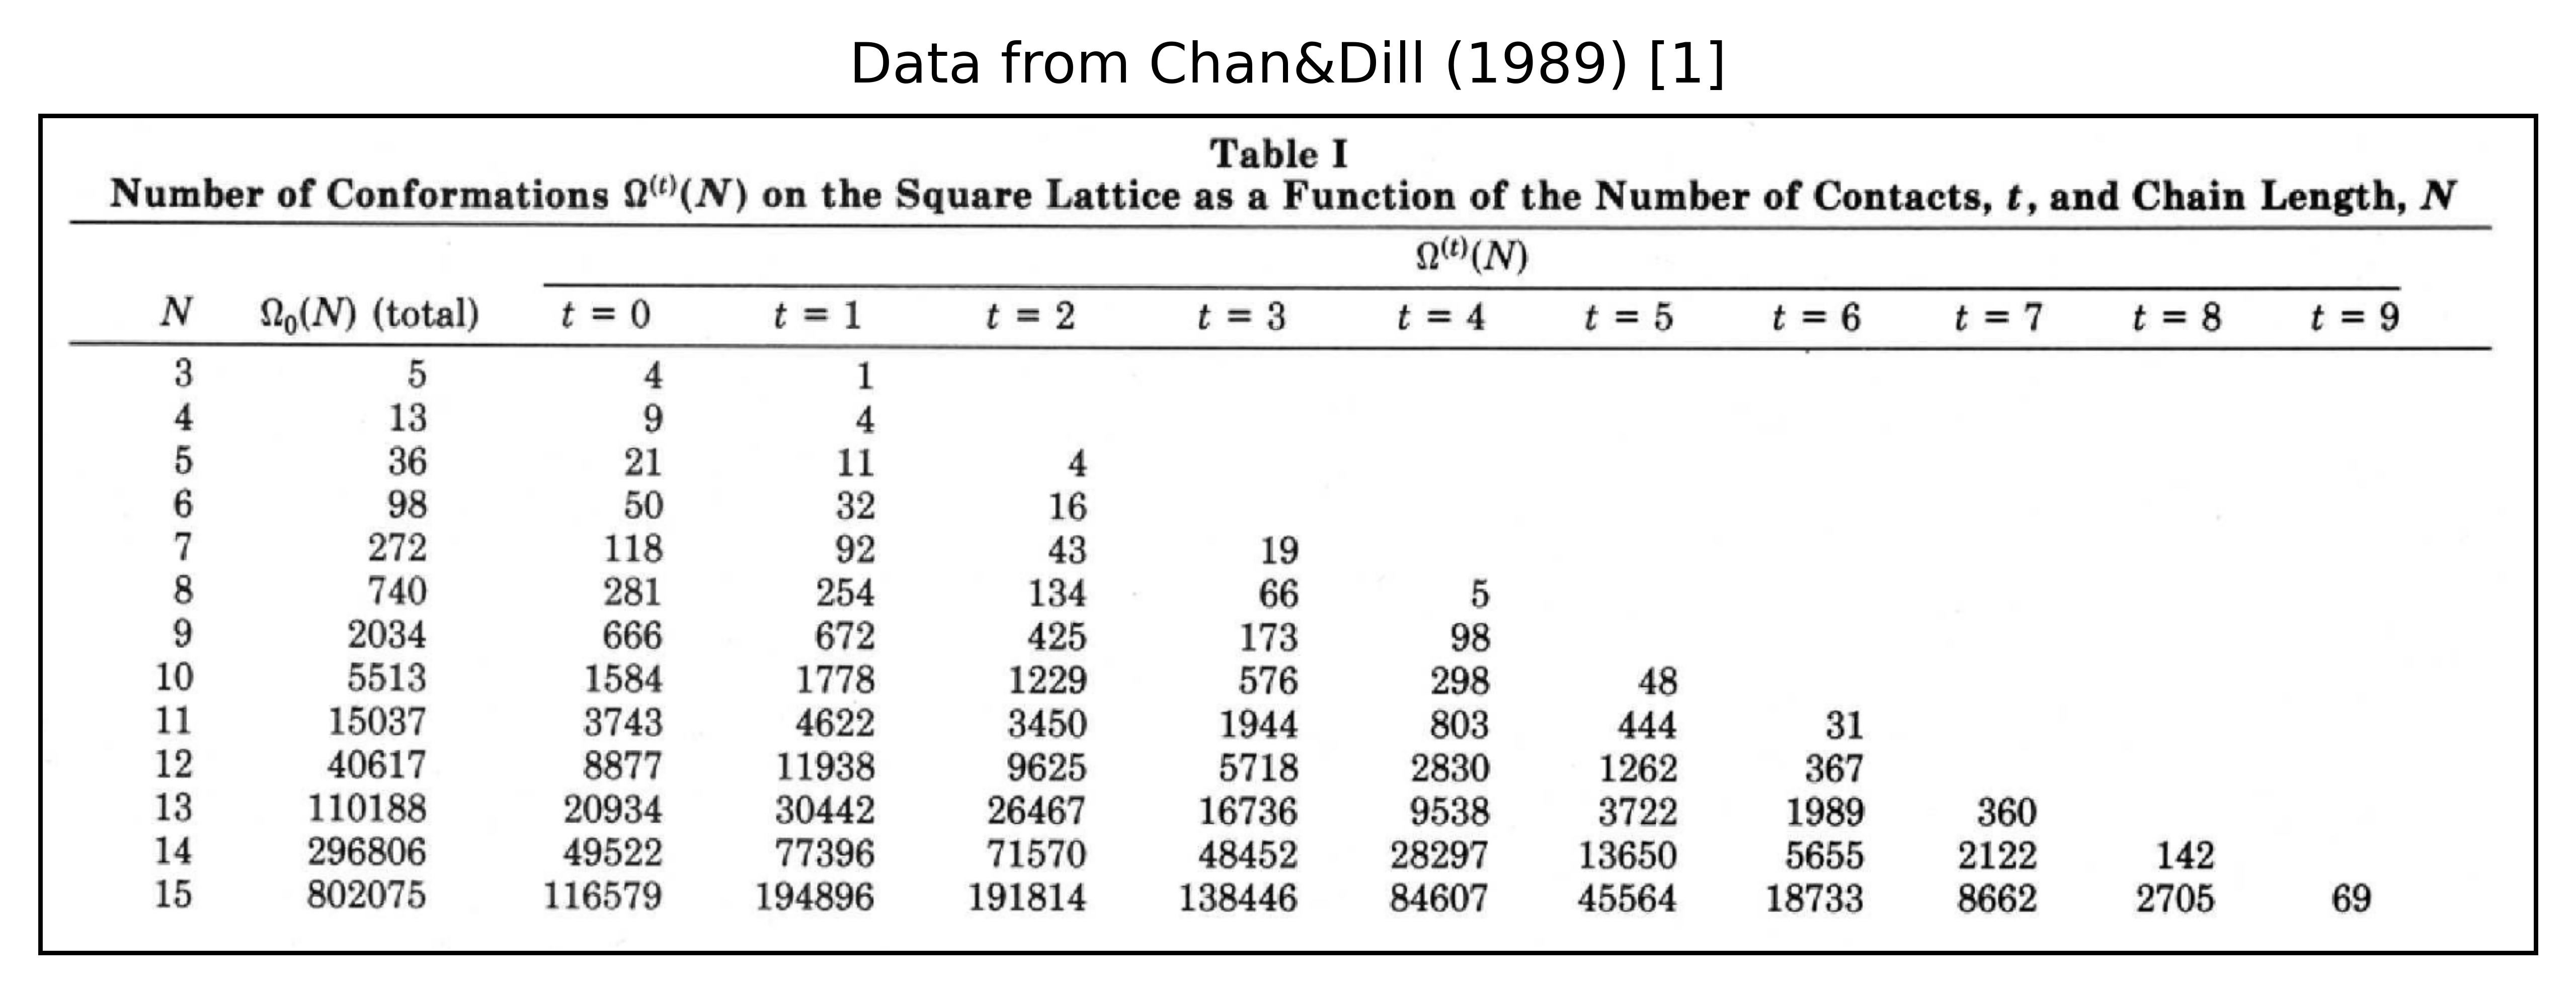

In [27]:
# Data processed to be displayed in tabular 

t_max = len(Omega_t[-1]) # max number of topological contacts for N=16 -> used for padding 
Omega_t_padded = []

# Zero-padding 
for omega_t in Omega_t:
    omega_t = np.pad(omega_t, (0,t_max-len(omega_t)), mode='constant' )
    Omega_t_padded.append(omega_t)
# stack Omega values for all t values
Omega_t_padded = np.vstack(Omega_t_padded)

# stack all columns appearing in table
Omega = np.array(Omega)
Omega_col = np.expand_dims(Omega,axis=-1)
Ns = np.expand_dims(np.arange(4,17), axis=-1)
table_values = np.hstack([Ns,Omega_col,Omega_t_padded])

# column headers
cols = ['N','Ω']
for t in range(t_max): cols.append(f't={t}')

# display table with plotly
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Table(
        header=dict(values=cols),
        cells=dict(values=np.transpose(table_values))),
])
fig.update_layout(
    title = dict(text='# Conformations for chain on N residues: total Ω and contribution Ω_t for t topological contacts',)
)
fig.show()

# Display original table
import matplotlib.image as img 
from PIL import Image

filepath = path + 'Table_Omega_vs_N.png'
plt.figure(figsize=[8,6],dpi=800)
image = Image.open(filepath)
plt.xticks([])
plt.yticks([])
plt.title('Data from Chan&Dill (1989) [1]',fontsize=10)
plt.imshow(image)
plt.show()


In the table above, the values for $\Omega(N)$ and $\{ \Omega^{(t)}(N) \}_{t=0}^{t_{max}}$ computed in the previous cells are reported.  Below, the same data from the Chan&Dill(1989) article [1] are displayed, so that one can easiliy check that the original results are correctly reproduced.

**NOTE** in the article, $N$ denotes the number of bonds in the chain instead of the number of residues, so all values of $N$ in the original table differ by $-1$ from the values of this notebook's code and output table.

### 1.2 Computing compactness

We can compute the distribution of the compactness $\rho$ over the possible chain conformations. Since for a fixed $N$ there is a fixed $t_{max}$, then $\rho \propto t$: therefore, computing the distribution of $\rho$ over the different conformations is equivalent to computing an histogram of $\Omega^{(t)}(N)$ varying $t=0,...,t_{max}$ for fixed $N$. We choose $N=16$ to reproduce the results in Figure 2 from [1]. Visually, the plot produced by the code and the original one appear to be in agreement.

In [28]:
N = 16
# generate all conformations (takes about 1 min to run)
confs = generate_conformations(N)

rhos, t_max = compute_compactness(confs)
print(len(rhos))
print(t_max)

802075
9


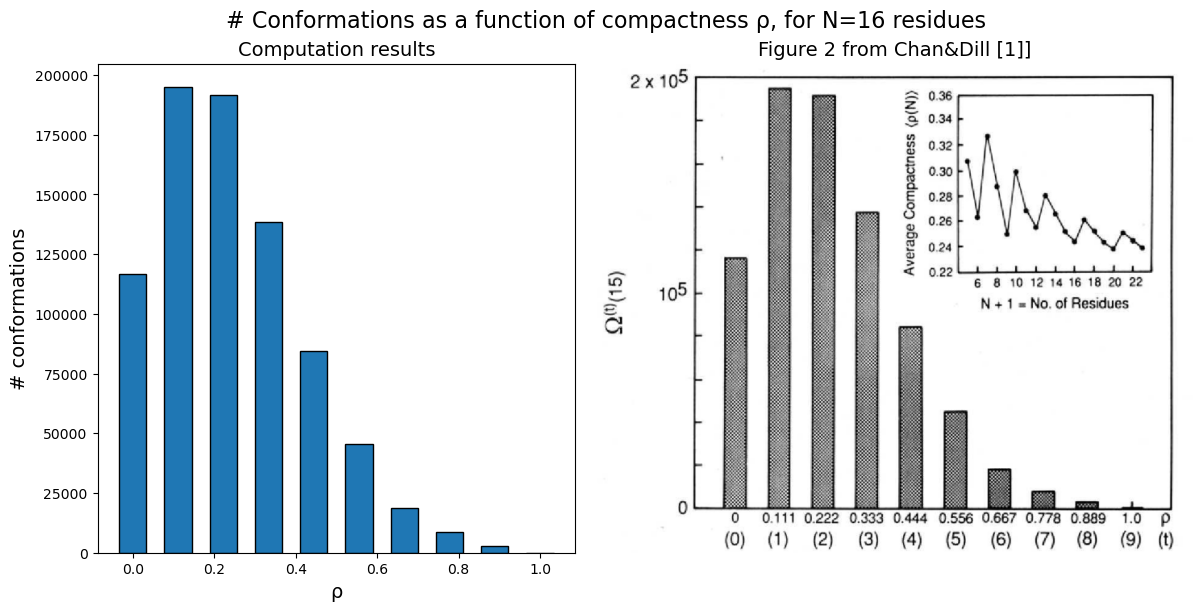

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [0.35, 0.45]}, constrained_layout=True)
fig.suptitle(f'# Conformations as a function of compactness ρ, for N=16 residues',fontsize=16)

# Plotting the distribution native state degeneracy
#axs[0].set_xlim([0,1])
bins = np.arange(t_max+2) / t_max
axs[0].hist(rhos, bins=bins, ec='black', align='left', rwidth=.6)
axs[0].set_xlabel('ρ',fontsize=14)
axs[0].set_ylabel('# conformations',fontsize=14)
axs[0].set_title('Computation results',fontsize=14)


# Display original plot from Lau&Dill article
filepath = path + 'rho_hist_N16.png'
image = Image.open(filepath)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_axis_off()
axs[1].set_title('Figure 2 from Chan&Dill [1]]',fontsize=14)
axs[1].imshow(image)


## 2 Reproducing Lau&Dill (1989): native states' properties  

For a chain of length $N$ with a given sequence, let $m=m(i)$ be the number of $HH$ topological contacts in a certain conformation $i$. Then we can define 
$$
g(m) \equiv \text{Number of conformations } i : m(i) = m 
$$ 
Exploring all the possible conformation of the chain, the number of $HH$ topological contacts will assume the values $m=0,1,...,s$. The states with the maximum allowed value $m=s$ are called *native* for that sequence. Therefore $g(s)$ is the number of native states (*degeneracy*) of the sequence. We can define the average compactness and core hydrophobicity over the native states respectively as
$$
\begin{align}
< \rho >_{ns} = \frac{1}{g(s)} \sum_{i=1}^{g(s)} \rho(i) \\
< x >_{ns} = \frac{1}{g(s)} \sum_{i=1}^{g(s)} x_i \\
\end{align}
$$
We now want compute, for a chain of a given length:
1. the distribution of the native states' degeneracy $g(s)$ in the space of all possible sequences;
2. the distribution of $<\rho>_{ns}$;
3. the distribution of $<x>_{ns}$.

To do so, we perform the following steps:
1. generate all spatial chain conformations for a given $N$;
2. generate all `HP` sequences of length $N$;
3. for each sequence, use `find_lowest_energy_conformations()` to compute $m$ for each possible conformation and find the ones with the lowest energy, i.e. the highest value $m=s$;
4. the number of these lowest-energy conformations is $g(s)$;
5. compute $\rho$ and $x$ for each lowest-energy conformation. By taking the average we obtain $<\rho>_{ns}$ and $<x>_{ns}$.

This procedure can be modified at point 1. by considering only the most compact conformations, i.e. conformations $i$ s.t. $t(i)=t_{max}$: in this case, we compute only $g(s)$ and $<x>_{ns}$, since $\rho$ is by construction 1.


In the following cells we compute the distribution of $g(s)$, $<\rho>_{ns}$ and $<x>_{ns}$ in the sequence space for $N=10$; the two approaches of sampling all conformations or just the most compact ones are implemented.  

In [30]:
N = 10
# generate all conformations
confs = generate_conformations(N)
# find most compact conformations
t_max, confs_compact = select_compact_conformations(confs)
# generate all sequences
seqs = generate_all_sequences(N)

g_ss = [] # native state degeneracies considering all conformations
rho_avgs = [] # native state compactness (considering all conformations)
x_avgs = [] # native state degree of hydrophobicity (considering all conformations)
g_ss_compact = [] # native state degeneracies considering only compact conformations 
x_avgs_compact = [] # native state degree of hydrophobicity (considering only compact conformations)

 
for s in tqdm(seqs):

    # From all conformations:
    # find native states
    E_min, confs_E_min = find_lowest_energy_conformations(s,confs)
    # native states degeneracy
    g_ss.append( len(confs_E_min) )
    # compactness
    rhos, _ = compute_compactness(confs_E_min) # compute compactness of native states
    rhos = np.array(rhos) # average over native states of the sequence
    rho_avgs.append( np.mean(rhos) )
    # core hydrophobicity
    xs = []
    for c in confs_E_min:
        core_idx, _ = find_core(c)
        x = compute_core_hydrophobicity(core_idx,s)
        xs.append(x)
    xs = np.array(xs)
    x_avgs.append(np.mean(xs) )  
    
    # From compact conformations only
    # native states
    E_min, confs_compact_E_min = find_lowest_energy_conformations(s,confs_compact)
    # native state degeneracy
    g_ss_compact.append( len(confs_compact_E_min) ) 
    # core hydrophobicity
    xs = []
    for c in confs_compact_E_min:
        core_idx, _ = find_core(c)
        x = compute_core_hydrophobicity(core_idx,s)
        xs.append(x)
    xs = np.array(xs)
    x_avgs_compact.append(np.mean(xs) ) 
    


100%|██████████| 1024/1024 [00:13<00:00, 75.87it/s]


### 2.1 Averages over all conformations

Here are the results obtained by sampling all the spatial conformations of a chain of length $N=10$. The plots are compared with the panels in figures 8 from Lau&Dill(1989) [2]. We can observe a good agreement of our results with the original ones, at least visually (since the numerical data used to generate the original histogram plots are not provided). 

Regarding the $g(s)$ distribution histogram, the agreement with [2] looks exact for the histograms in the small boxes, which display the occurences of $g(s)\in\{1,2,...,20\}$ with a bin width = 1. For the histograms in the large pictures, the authors chose a bin size which is not specified in the article: by trial and error, my best guess is a bin size of 20, which allows to reproduce very similar - but not exactly identical - plots. Dicrepancies could then arise from a difference in binning (from my attempts, I would exclude any bin width >25, but it would have been somehow unusual for the authors to choose some number in between 21 and 24), or may be due to the poor quality of the original images.

For what concerns $<\rho>_{ns}$ and $<x>_{ns}$, by looking carefully at the histograms, they are overall quite similar to the original ones, but there are visible discrepancies in some few bins.

In [38]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

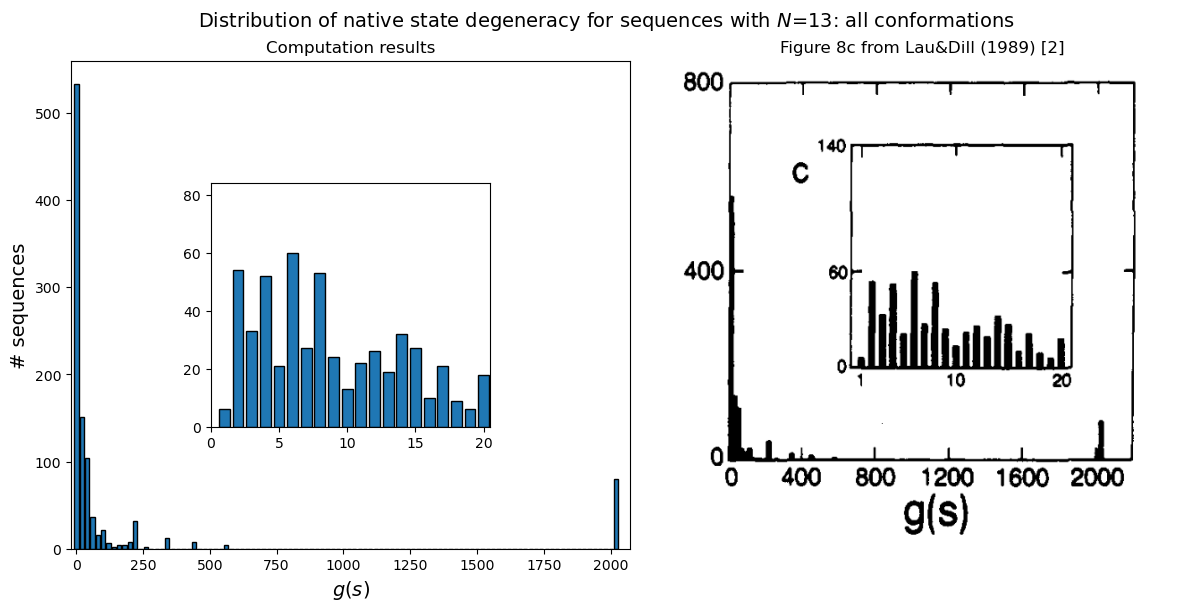

In [39]:
# NATIVE STATE DEGENERACY

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [0.4, 0.4]}, constrained_layout=True)
fig.suptitle(f'Distribution of native state degeneracy for sequences with $N$={N}: all conformations',fontsize=14)

# Plotting the distribution native state degeneracy
binwidth = 20
axs[0].set_xlim([-binwidth,max(g_ss)+2*binwidth])
axs[0].hist(g_ss, bins=np.arange(1, max(g_ss) + binwidth,binwidth), ec='black', align='left', rwidth=0.8)
axs[0].set_xlabel('$g(s)$',fontsize=14)
axs[0].set_ylabel('# sequences',fontsize=14)
axs[0].set_title('Computation results',fontsize=12)
inset_ax = inset_axes(axs[0], width="50%", height="50%", loc="center")  # Width and height as percentage
inset_ax.hist(g_ss, bins=np.arange(1, max(g_ss) + 1), ec='black', align='left', rwidth=0.8)
inset_ax.set_xlim([0,20.5])

# Display original plot from Lau&Dill article
filepath = path + 'g(s)_distrib_N10.png'
image = Image.open(filepath)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_axis_off()
axs[1].set_title('Figure 8c from Lau&Dill (1989) [2]',fontsize=12)
axs[1].imshow(image)



plt.show()

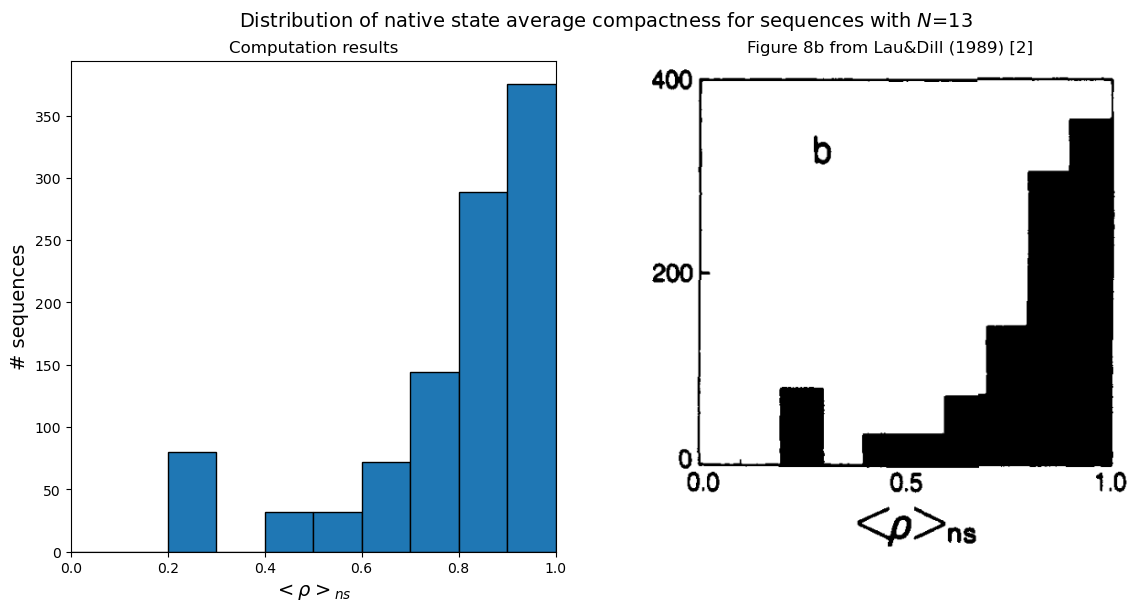

In [37]:
# COMPACTNESS

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [0.35, 0.45]}, constrained_layout=True)
fig.suptitle(f'Distribution of native state average compactness for sequences with $N$={N}',fontsize=14)

# Plotting the distribution native state compactness
axs[0].hist(rho_avgs, bins=10, range=[0,1], ec='black', rwidth=1)
axs[0].set_xlim([0,1])
axs[0].set_xlabel('$ < ρ >_{ns} $',fontsize=14)
axs[0].set_ylabel('# sequences',fontsize=14)
axs[0].set_title('Computation results',fontsize=12)

# Display original plot from Lau&Dill article
filepath = path + 'rho_hist_native_N10.png'
image = Image.open(filepath)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_axis_off()
axs[1].set_title('Figure 8b from Lau&Dill (1989) [2]',fontsize=12)
axs[1].imshow(image)

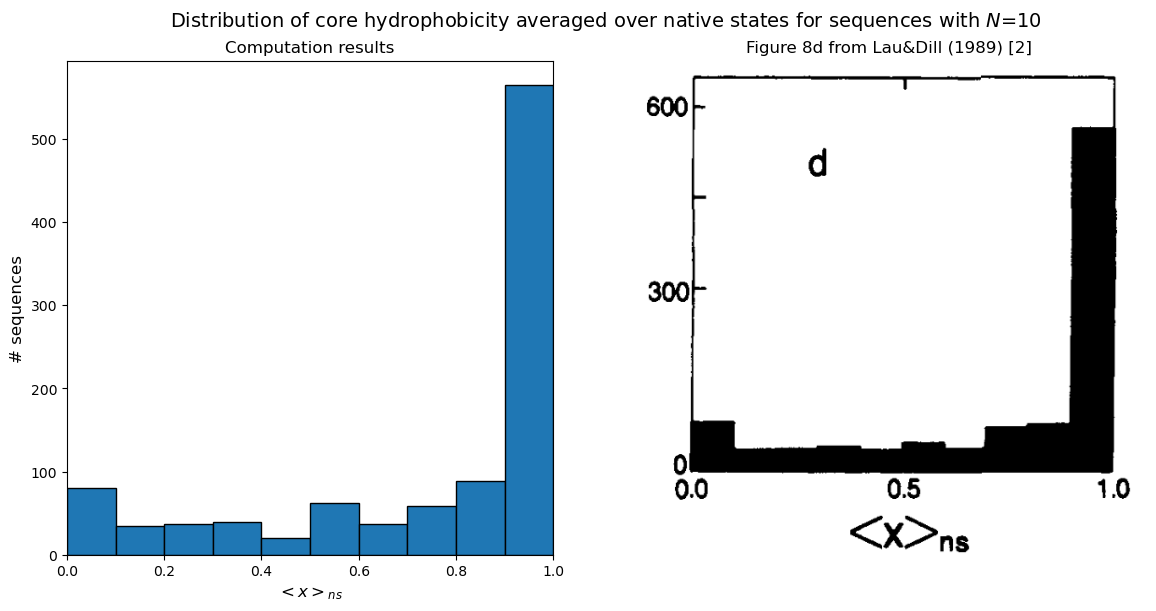

In [32]:
# CORE HYDROPHOBICITY

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [0.35, 0.45]}, constrained_layout=True)
fig.suptitle(f'Distribution of core hydrophobicity averaged over native states for sequences with $N$={N}',fontsize=14)

# Plotting the distribution native state compactness
axs[0].hist(x_avgs, bins=10, range=[0,1], ec='black', rwidth=1)
axs[0].set_xlim([0,1])
axs[0].set_xlabel('$ < x >_{ns} $',fontsize=12)
axs[0].set_ylabel('# sequences',fontsize=12)
axs[0].set_title('Computation results',fontsize=12)

# Display original plot from Lau&Dill article
filepath = path + 'x_hist_native_N10.png'
image = Image.open(filepath)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_axis_off()
axs[1].set_title('Figure 8d from Lau&Dill (1989) [2]',fontsize=12)
axs[1].imshow(image)

### 2.2 Averages over compact conformations

Here are the results obtained by sampling only the compact conformations of a chain of length $N=10$. The plots are compared with figures 12 from Lau&Dill(1989) [2]. The same observations made for the plots in section 2.1 apply.

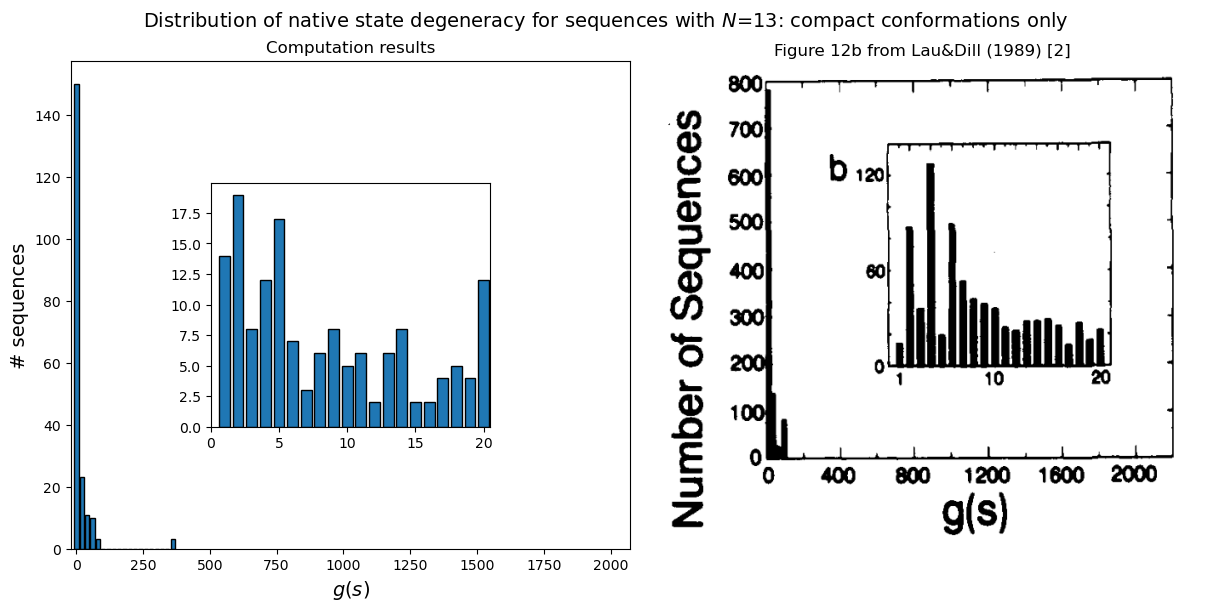

In [40]:
# NATIVE STATE DEGENERACY

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [0.4, 0.4]}, constrained_layout=True)
fig.suptitle(f'Distribution of native state degeneracy for sequences with $N$={N}: compact conformations only',fontsize=14)

# Plotting the distribution native state degeneracy
binwidth = 20
axs[0].set_xlim([-binwidth,max(g_ss)+2*binwidth])
axs[0].hist(g_ss_compact, bins=np.arange(1, max(g_ss_compact) + binwidth,binwidth), ec='black', align='left', rwidth=0.8)
axs[0].set_xlabel('$g(s)$',fontsize=14)
axs[0].set_ylabel('# sequences',fontsize=14)
axs[0].set_title('Computation results',fontsize=12)
inset_ax = inset_axes(axs[0], width="50%", height="50%", loc="center")  # Width and height as percentage
inset_ax.hist(g_ss_compact, bins=np.arange(1, max(g_ss_compact) + 1), ec='black', align='left', rwidth=0.8)
inset_ax.set_xlim([0,20.5])

# Display original plot from Lau&Dill article
filepath = path + 'g(s)_distrib_N10_compact.png'
image = Image.open(filepath)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_axis_off()
axs[1].set_title('Figure 12b from Lau&Dill (1989) [2]',fontsize=12)
axs[1].imshow(image)



plt.show()

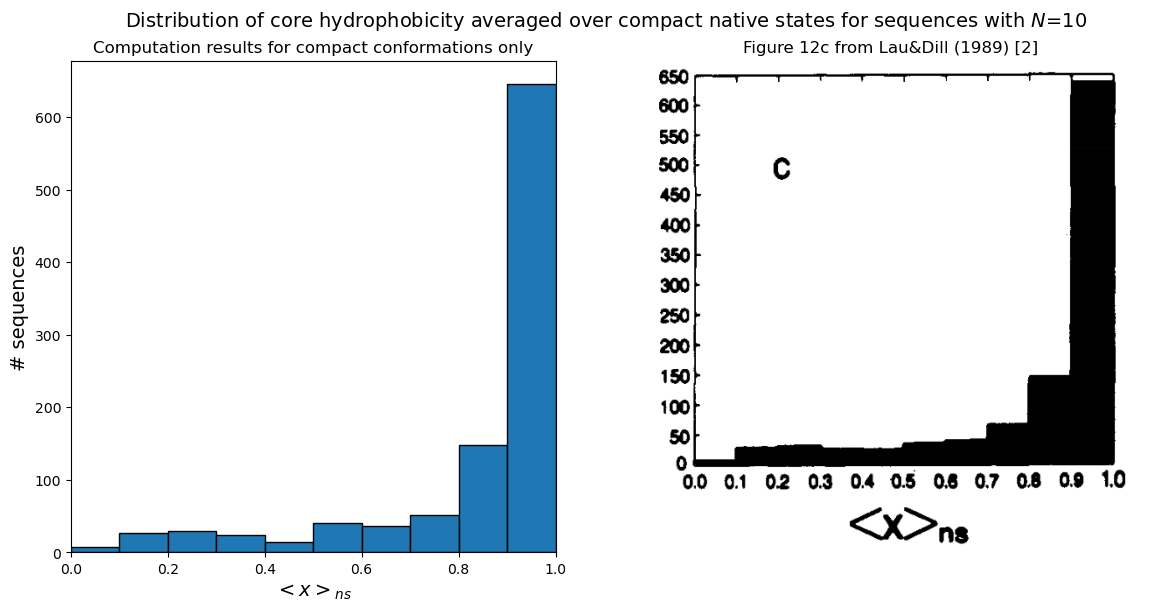

In [33]:
# CORE HYDROPHOBICITY

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [0.35, 0.45]}, constrained_layout=True)
fig.suptitle(f'Distribution of core hydrophobicity averaged over compact native states for sequences with $N$={N}',fontsize=14)

# Plotting the distribution native state compactness
axs[0].hist(x_avgs_compact, bins=10, range=[0,1], ec='black', rwidth=1)
axs[0].set_xlim([0,1])
axs[0].set_xlabel('$ < x >_{ns} $',fontsize=14)
axs[0].set_ylabel('# sequences',fontsize=14)
axs[0].set_title('Computation results for compact conformations only',fontsize=12)

# Display original plot from Lau&Dill article
filepath = path + 'x_hist_native_compact_N10.png'
image = Image.open(filepath)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_axis_off()
axs[1].set_title('Figure 12c from Lau&Dill (1989) [2]',fontsize=12)
axs[1].imshow(image)

### 2.3 Sampling sequences

We now compute the distributions of $g(s)$ and $<x>_{ns}$ for $N=13$, considering only the compact conformations; this time, to save computational time, we do not consider all the `HP` sequences, but instead randomly sample 200 of them. Then we compare the results to figure 13 from [2]. Here the agreement with the article's figures is unlikely  to be exact $^*$, since the sequences are sampled casually: anyway, the overall features of the histograms are comparable. 

As can be seen in the $g(s)$ histogram, the effect of increasing $N$ is to make the distribution of more peaked around low values, with a faster decay as $g(s)$ increases. 

For what concerns the $<x>_{ns}$ distribution, it appears to become more skewed towards values in the higher end of the $[0,1]$ interval, i.e. the hydrophobicity of the core is favoured by a larger $N$.

$*$ It actually could be exact, if one was so lucky to run the cell and randomly get, out of $M=2^{13}$ sequences, the same $m=200$ used by Lau&Dill: the probability of such an event is
$$
 1 \bigg/ \binom{M}{m} = \frac{m!(M-m)!}{M!} \overset{\text{Stirling}}{\approx} = \sqrt{2\pi} \Big(\frac{m}{M}\Big)^m \Big( 1 - \frac{m}{M} \Big)^{M-m} < \sqrt{2\pi} \Big(\frac{m}{M}\Big)^m  \sim 10^{-323}
$$

In [34]:
import random

In [35]:
N = 13
n_seq = 200 
# generate all conformations
confs = generate_conformations(N)
# find most compact conformations
t_max, confs_compact = select_compact_conformations(confs)
# generate all sequences
seqs = generate_all_sequences(N)
# shuffle randomly the sequence list and take first 200 
random.shuffle(seqs) # shuffle() method modifies the existing list, does not create a new one!
seqs_sample = seqs[:n_seq]
print('# sampled sequences = ',len(seqs_sample))

g_ss_compact = [] 
x_avgs = []

# compute native states degeneracy 
for s in tqdm(seqs_sample):
    
    # compact conformations only
    E_min, confs_compact_E_min = find_lowest_energy_conformations(s,confs_compact)
    
    # native state degeneracy
    g_ss_compact.append( len(confs_compact_E_min) ) 

    # core hydrophobicity
    xs = []
    for c in confs_compact_E_min:
        core_idx, _ = find_core(c)
        x = compute_core_hydrophobicity(core_idx,s)
        xs.append(x)
    xs = np.array(xs)
    x_avgs.append(np.mean(xs) )  


# sampled sequences =  200


100%|██████████| 200/200 [00:00<00:00, 397.21it/s]


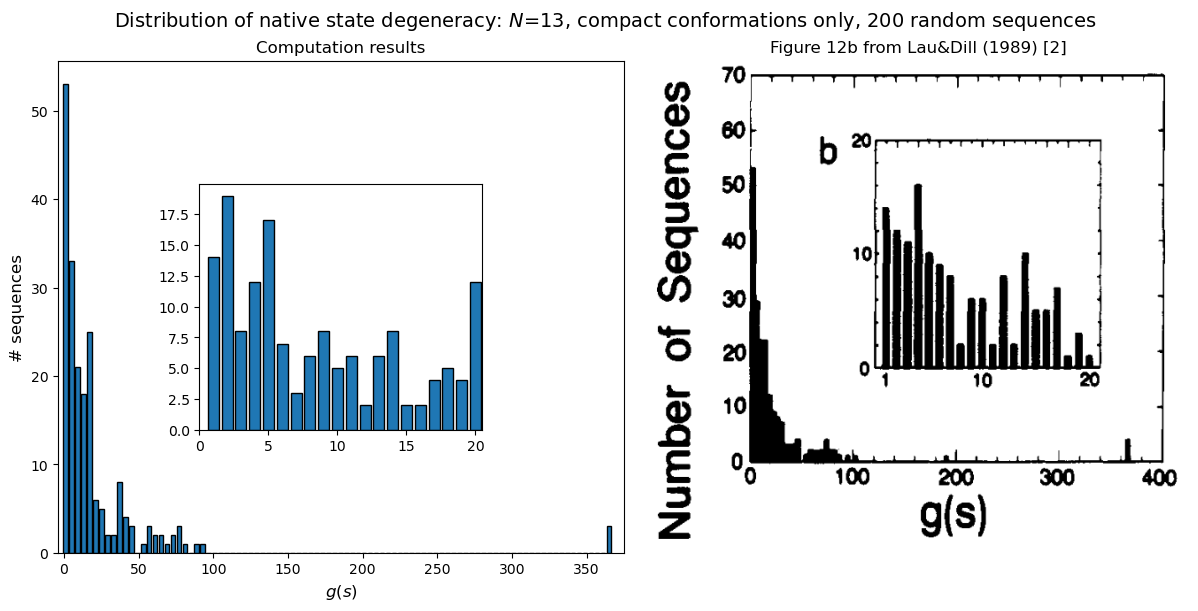

In [41]:
# NATIVE STATE DEGENERACY

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [0.4, 0.4]}, constrained_layout=True)
fig.suptitle(f'Distribution of native state degeneracy: $N$={N}, compact conformations only, {n_seq} random sequences ',fontsize=14)

# Plotting the distribution native state degeneracy
binwidth = 4
axs[0].set_xlim([-binwidth,max(g_ss_compact)+2*binwidth])
axs[0].hist(g_ss_compact, bins=np.arange(1, max(g_ss_compact) + binwidth,binwidth), ec='black', align='left', rwidth=0.8)
axs[0].set_xlabel('$g(s)$',fontsize=12)
axs[0].set_ylabel('# sequences',fontsize=12)
axs[0].set_title('Computation results',fontsize=12)
inset_ax = inset_axes(axs[0], width="50%", height="50%", loc="center")  # Width and height as percentage
inset_ax.hist(g_ss_compact, bins=np.arange(1, max(g_ss_compact) + 1), ec='black', align='left', rwidth=0.8)
inset_ax.set_xlim([0,20.5])

# Display original plot from Lau&Dill article
path = '/Users/tommaso/Library/Mobile Documents/com~apple~CloudDocs/Documents/Fisica_Magistrale/CompBioPhys/Homework2-HP/'
path += 'g(s)_distrib_N13_compact.png'
image = Image.open(path)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_axis_off()
axs[1].set_title('Figure 12b from Lau&Dill (1989) [2]',fontsize=12)
axs[1].imshow(image)

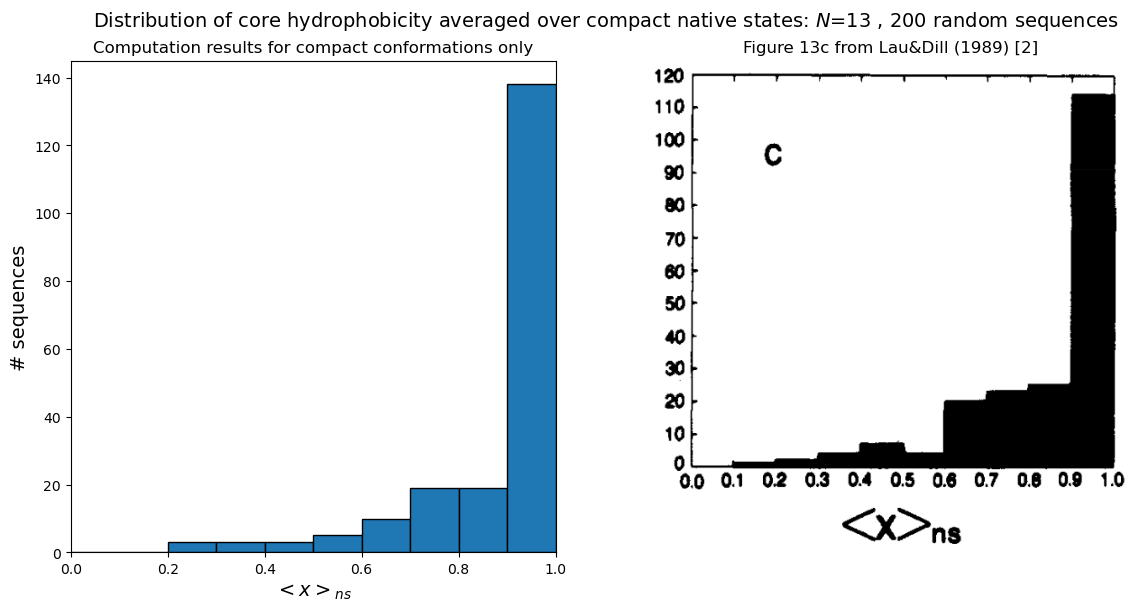

In [36]:
# CORE HYDROPHOBICITY

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [0.35, 0.45]}, constrained_layout=True)
fig.suptitle(f'Distribution of core hydrophobicity averaged over compact native states: $N$={N} , 200 random sequences',fontsize=14)

# Plotting the distribution native state compactness
axs[0].hist(x_avgs, bins=10, range=[0,1], ec='black', rwidth=1)
axs[0].set_xlim([0,1])
axs[0].set_xlabel('$ < x >_{ns} $',fontsize=14)
axs[0].set_ylabel('# sequences',fontsize=14)
axs[0].set_title('Computation results for compact conformations only',fontsize=12)

# Display original plot from Lau&Dill article
filepath = path + 'x_hist_native_compact_N13.png'
image = Image.open(filepath)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_axis_off()
axs[1].set_title('Figure 13c from Lau&Dill (1989) [2]',fontsize=12)
axs[1].imshow(image)